In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal

from Novel_Metrics_and_Plotting_utils import *
from metrics import *
# Use seaborn's notebook context for larger fonts and plot size
sns.set_context("notebook", font_scale=1.25,rc={"lines.linewidth": 2.5})

In [2]:
base_folder = "SNAPSHOT_Sleep_results"
label_type = "Cohort_2" #"Calm or peaceful"
results_df = load_perf_results(base_folder, label_type)

In [5]:

# Filter the DataFrame for a fixed L value (e.g., L=3) and specific graph_type 'L_friend'
filtered_df = results_df[(results_df['L'] == 3) & (results_df['graph_type'] == 'L_friend')]

# Group by 'k', 'strategy', 'graph_type', 'label_type', and 'node_type' and calculate the mean of performance metrics
average_metrics_df = filtered_df.groupby(['k', 'strategy', 'graph_type', 'label_type', 'node_type']).agg(
    mean_f1_macro=('f1_macro', 'mean')
).reset_index()

# Update labels for node types
average_metrics_df['node_type'] = average_metrics_df['node_type'].replace({
    'test_set_same_day': 'Hold-out Set',
    'unqueried_nodes_same_day': 'Query Pool (unqueried)'
})

# Node types to plot with updated names
node_types_to_plot = ['Hold-out Set', 'Query Pool (unqueried)']

# Define a color palette
pal = 'tab20'

# Plotting function for specific node types and macro F1 without error bars
for node_type in node_types_to_plot:
    node_type_df = average_metrics_df[average_metrics_df['node_type'] == node_type]
    
    # Get unique label types for the title
    unique_label_types = node_type_df['label_type'].unique()
    
    for label_type in unique_label_types:
        label_df = node_type_df[node_type_df['label_type'] == label_type]
        
        # Create a new figure for each node type
        plt.figure(figsize=(12, 8))
        sns.lineplot(
            data=label_df,
            x='k',
            y='mean_f1_macro',
            hue='strategy',
            markers=True,  # Display markers on the plot
            style='strategy',  # Use different styles for different strategies
            dashes=False,  # Ensure solid lines for clarity
            palette=pal,
            ci=None  # Disable Seaborn's confidence interval shading
        )
        
        plt.title(f'Average Macro F1 vs K for L=3 (Node Type: {node_type}, Graph Type: Friendship, Label Type: {label_type})')
        plt.xlabel('K')
        plt.ylabel('Average Macro F1')
        plt.grid(True)

        # Move the legend further to the right
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, labels, title='Strategy', bbox_to_anchor=(1.2, 0.5), loc='center', borderaxespad=0.)

      #  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legend
        plt.show()


In [12]:
# Define node types to analyze
node_types_to_plot = ['unqueried_nodes_same_day', 'test_set_same_day', 'unqueried_nodes_next_day', 'train_nodes_next_day']

# Compute CPI for each unique combination of L and k
cpi_results = []
for L_value in results_df['L'].unique():
    for k_value in results_df['k'].unique():
        subset_df = results_df[(results_df['L'] == L_value) & (results_df['k'] == k_value)]
        cpi_summary = compute_cpi_summary(subset_df, f"L={L_value}, k={k_value}",metric='accuracy')
        cpi_summary['L'] = L_value
        cpi_summary['k'] = k_value
        cpi_results.append(cpi_summary)

# Combine all CPI results into a single DataFrame
cpi_df = pd.concat(cpi_results, ignore_index=True)



In [ ]:
## A function to create a consolidated table for a given metric
def create_performance_table(df, metric, fixed_L, fixed_k, cpi_df=None):
    """
    Creates a consolidated table for a given metric for fixed L and k.
    
    Parameters:
    - df: DataFrame with performance metrics (results_df).
    - metric: String, the name of the metric to be used as table entries.
    - fixed_L: The fixed value of L.
    - fixed_k: The fixed value of k.
    - cpi_df: DataFrame with CPI data if the metric is CPI.
    
    Returns:
    - performance_table: A DataFrame where rows are strategies, columns are node types,
                         and entries are mean (std) of the given metric.
    """
    if metric == 'CPI' and cpi_df is not None:
        filtered_df = cpi_df[(cpi_df['L'] == fixed_L) & (cpi_df['k'] == fixed_k)]
        mean_col = 'mean_CPI'
        std_col = 'std_CPI'
    else:
        filtered_df = df[(df['L'] == fixed_L) & (df['k'] == fixed_k)]
        mean_col = metric
        std_col = f"{metric}_std"  # This column won't be used since std is computed on the fly
    
    performance_data = []
    strategies = filtered_df['strategy'].unique()
    node_types = filtered_df['node_type'].unique()  # Get all unique node types
    
    # Create the performance data for each strategy and node type
    for strategy in strategies:
        row = {'strategy': strategy}
        for node_type in node_types:
            node_df = filtered_df[(filtered_df['strategy'] == strategy) & (filtered_df['node_type'] == node_type)]
            if not node_df.empty:
                mean_value = node_df[mean_col].iloc[0] if metric == 'CPI' else node_df[mean_col].mean()
                std_value = node_df[std_col].iloc[0] if metric == 'CPI' else node_df[mean_col].std()
                row[node_type] = f"{mean_value:.2f} ({std_value:.2f})"
            else:
                row[node_type] = "N/A"
        performance_data.append(row)
    
    # Convert to DataFrame
    performance_table = pd.DataFrame(performance_data)
    performance_table.set_index('strategy', inplace=True)
    return performance_table

# Create performance tables for each metric
#metrics = ['accuracy', 'precision', 'recall', 'ROC_AUC', 'AUC_PR', 'f1_micro', 'f1_macro', 'CPI']
metrics = ['accuracy',   'f1_macro', 'CPI']
fixed_L = 8
fixed_k = 9

# Generate tables for each metric
tables = {}
for metric in metrics:
    tables[metric] = create_performance_table(results_df, metric, fixed_L, fixed_k, cpi_df)

# Display tables (example for accuracy and CPI)
for metric, table in tables.items():
    print(f"\nPerformance Table for {metric}:")
    print(table)



Performance Table for accuracy:
                             train_nodes_next_day unqueried_nodes_same_day  \
strategy                                                                     
graphpart                             0.78 (0.18)              0.75 (0.11)   
age                                   0.84 (0.14)              0.79 (0.11)   
coreset                               0.82 (0.17)              0.81 (0.13)   
featProp                              0.86 (0.14)              0.80 (0.11)   
density                               0.83 (0.14)              0.80 (0.10)   
graphpartfar                          0.82 (0.16)              0.78 (0.11)   
uncertainty_entropy                   0.81 (0.16)              0.83 (0.12)   
uncertainty_least_confidence          0.81 (0.16)              0.82 (0.12)   
uncertainty_margin                    0.80 (0.16)              0.75 (0.14)   
pagerank                              0.81 (0.16)              0.78 (0.12)   
degree                         

In [ ]:
## Filter results for L=3 and k=5
fixed_L = 3
fixed_k = 5
filtered_results_df = results_df[(results_df['L'] == fixed_L) & (results_df['k'] == fixed_k)]

# Compute CPI values using f1_macro as the metric
_, cpi_values_df = compute_cpi_full(filtered_results_df, label_name="Specified_Label", metric='f1_macro')

# List of metrics to test
metrics = ['accuracy', 'f1_macro', 'CPI']

# Merge CPI values with the filtered results
merged_df = pd.merge(
    filtered_results_df, 
    cpi_values_df[['strategy', 'node_type', 'bootstrap_iteration', 'CPI']],
    on=['strategy', 'node_type', 'bootstrap_iteration'],
    how='left'
)

# Initialize a list to store test results
test_results = []

# Loop through each combination of node_type, graph_type, and label_type
for (node_type, graph_type, label_type), group in merged_df.groupby(['node_type', 'graph_type', 'label_type']):
    # Exclude `no_AL` strategy if node_type is 'train_nodes_same_day'
    if node_type == 'train_nodes_next_day':
        group = group[group['strategy'] != 'no_AL']
    
    # Perform the tests for each metric
    for metric in metrics:
        metric_column = 'CPI' if metric == 'CPI' else metric
        
        strategy_groups = [group[group['strategy'] == strategy][metric_column].dropna().values for strategy in group['strategy'].unique()]
        
        if all(len(values) > 1 for values in strategy_groups):
            anova_stat, anova_p = f_oneway(*strategy_groups)
        else:
            anova_stat, anova_p = float('nan'), float('nan')

        kruskal_stat, kruskal_p = kruskal(*strategy_groups)
        
        test_results.append({
            'node_type': node_type,
            'graph_type': graph_type,
            'label_type': label_type,
            'metric': metric,
            'ANOVA F-statistic': anova_stat,
            'ANOVA p-value': anova_p,
            'Kruskal-Wallis H-statistic': kruskal_stat,
            'Kruskal-Wallis p-value': kruskal_p
        })

# Convert test results to DataFrame for better readability
test_results_df = pd.DataFrame(test_results)

# Display the results
print("Statistical Test Results for Each Metric by Node Type, Graph Type, and Label Type:")
print(test_results_df)


Statistical Test Results for Each Metric by Node Type, Graph Type, and Label Type:
                   node_type graph_type        label_type    metric  \
0          test_set_same_day   L_friend  Calm or peaceful  accuracy   
1          test_set_same_day   L_friend  Calm or peaceful  f1_macro   
2          test_set_same_day   L_friend  Calm or peaceful       CPI   
3       train_nodes_next_day   L_friend  Calm or peaceful  accuracy   
4       train_nodes_next_day   L_friend  Calm or peaceful  f1_macro   
5       train_nodes_next_day   L_friend  Calm or peaceful       CPI   
6   unqueried_nodes_next_day   L_friend  Calm or peaceful  accuracy   
7   unqueried_nodes_next_day   L_friend  Calm or peaceful  f1_macro   
8   unqueried_nodes_next_day   L_friend  Calm or peaceful       CPI   
9   unqueried_nodes_same_day   L_friend  Calm or peaceful  accuracy   
10  unqueried_nodes_same_day   L_friend  Calm or peaceful  f1_macro   
11  unqueried_nodes_same_day   L_friend  Calm or peaceful       C

/var/folders/_m/k69y2y316331v5rsyhpwrbgc0000gp/T/ipykernel_68655/174062884.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[rolling_col_name] = df.groupby(['strategy', 'bootstrap_iteration'])[metric].transform(


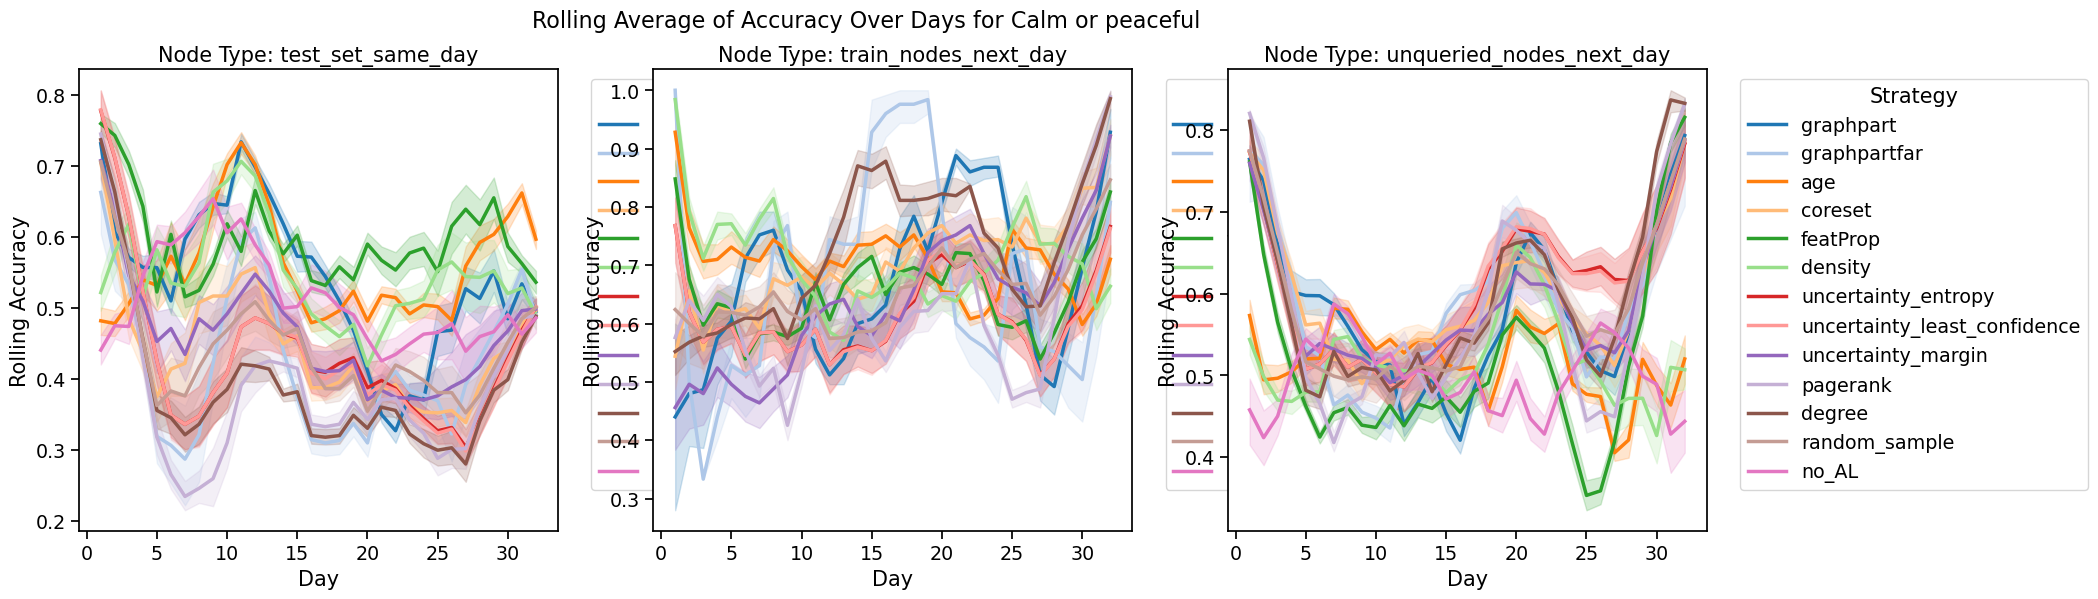

In [ ]:
# Function to plot rolling average for specific node types and metric
def plot_rolling_for_selected_nodes(df, label_name, node_types_to_plot, metric='accuracy', window_size=5):
    # Filter data for specific L and k values
    df = df[(df['L'] == 3) & (df['k'] == 5)]
    
    # Calculate rolling average for each strategy and bootstrap
    rolling_col_name = f'rolling_{metric}'
    df[rolling_col_name] = df.groupby(['strategy', 'bootstrap_iteration'])[metric].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    
    # Create a subplot grid for the selected node types
    fig, axes = plt.subplots(1, len(node_types_to_plot), figsize=(21, 6))
    fig.suptitle(f'Rolling Average of {metric.capitalize()} Over Days for {label_name}', fontsize=16)
    
    # Loop through each selected node type and create a plot
    for i, node_type in enumerate(node_types_to_plot):
        ax = axes[i] if len(node_types_to_plot) > 1 else axes  # Handle single plot case
        sns.lineplot(
            data=df[df['node_type'] == node_type],
            x='day',
            y=rolling_col_name,
            hue='strategy',
            ax=ax,
             palette='tab20'
        )
        ax.set_title(f'Node Type: {node_type}')
        ax.set_xlabel('Day')
        ax.set_ylabel(f'Rolling {metric.capitalize()}')
        ax.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout and display
   # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Define node types to plot
node_types_to_plot = [ 'test_set_same_day','train_nodes_next_day','unqueried_nodes_next_day']

# Plot for Stressed
plot_rolling_for_selected_nodes(results_df, "Calm or peaceful", node_types_to_plot, metric='accuracy',window_size=5)

# # Plot for Sleep
# plot_rolling_for_selected_nodes(results_df, "Sleep Class", node_types_to_plot, metric='accuracy')
